# Day-in-the-Life Simulation of a Satellite
This Jupyter Notebook demonstrates a day-in-the-life simulation of a satellite in orbit using the `nominalpy` library. The simulation covers various subsystems, including:
- Attitude and Orbit Control System (AOCS)
- Power Management
- Telemetry, Tracking & Command (TT&C), and 
    - Three ground-stations
    - Commands will drive the satellite's operation
- Mission Operations.
    - The mission includes an optical payload for simulating image capture
    - The mission will feature on-board data storage management
  


In [1]:
# Install and import necessary libraries
import os
import numpy as np
from datetime import datetime

from nominalpy import types, Object, Simulation, System
from nominalpy.maths import astro
from nominalpy.maths.computer_library import create_guidance_command
from nominalpy.maths.constants import RPM
from nominalpy.maths.data import megabytes_to_bits
from nominalpy import Credentials


## Authentication
To run the simulation, you need to authenticate with the `nominalpy` API. You can obtain an API key by signing up at www.nominalsys.com. Once you have the API key, you can use it to authenticate with the API.

In [2]:
from credential_helper import fetch_credentials

# Construct the credentials
# fetch the key from the environment variables, or set it here
key = os.environ.get('NOMINAL_API_KEY')


credentials = fetch_credentials()

## Overview of the Simulation
The simulation begins with initializing the satellite's orbit and adding key subsystems. The following sections will walk you through the setup and execution of the simulation.


In [3]:
# Initialize the simulation with a specific epoch

simulation: Simulation = Simulation.get(credentials)

## Create the universe including the environment models

In [4]:
# universe configuration parameters
planet = "earth"
epoch = datetime(2021, 1, 15, hour=0, minute=28, second=30)
# spherical harmonics model parameters
harmonics = 0
harmonics_file = "GGM03S.txt"
# magnetic field model parameters
G10 = -15463 
G11 = -1159 
H11 = 2908.5 
min_reach = -1 
max_reach = -1 

In [5]:
# create the universe
universe: System = simulation.get_system(
    types.SOLAR_SYSTEM,
    Epoch=epoch
)

# add the spherical harmonics model for the Earth's gravity field
if harmonics > 0:
    universe.invoke("SetSphericalHarmonics", planet, harmonics, harmonics_file)

# add a magnetic field model for reaction wheel desaturation
universe.invoke(
    "CreateMagneticFieldCenteredDipole",
    "earth",
    G10,
    G11,
    H11,
    min_reach,
    max_reach,
)

## Create the satellite

In [6]:
# satellite configuration parameters
semi_major_axis = 7000e3  # m
eccentricity = 0.001
inclination = 97.5  # deg
raan = 0  # deg
arg_perigee = 0  # deg
true_anomaly = 0  # deg

# initial attitude and rate, defined in modified rodriquez parameters
attitude = np.array([0.1, 0.2, -0.3])
attitude_rate = np.array([0.001, -0.01, 0.03])

In [7]:
# convert the classical orbital elements to state vectors to initialise the orbit
orbit: tuple = astro.classical_to_vector_elements_deg(
    semi_major_axis=semi_major_axis,
    eccentricity=eccentricity,
    inclination=inclination,
    right_ascension=raan,
    argument_of_periapsis=arg_perigee,
    true_anomaly=true_anomaly,
)

# add the satellite object to the simulation
# nominalpy can either set the mass properties of the spacecraft manually or calculate them based on attached components. In this case, we will calculate them based on components by setting the OverrideMass property to False.
spacecraft: Object = simulation.add_object(
    types.SPACECRAFT,
    Position=orbit[0],
    Velocity=orbit[1],
    Attitude=attitude,
    AttitudeRate=attitude_rate,
    OverrideMass=False
)

### Accounting for mass associated with components that we are NOT modelling
In this demo, we account for a subset of components that are typically found on a satellite. We will calculate the mass properties of the spacecraft based on the components that we are modelling. However, there are components that we do not need to model, such as the structure, that add mass. We can account for these by defining a hub with inertia properties that represent the mass of the unmodelled components.

In [8]:
# define the hub
hub = spacecraft.add_child(
    types.PHYSICAL_OBJECT,
)
mass = 500.0  # kg
moi_hub = np.diag([900.0, 800.0, 600.0])  # kg m^2
hub.set(Mass=mass)
hub.set(MomentOfInertia_LB=moi_hub)

## Add the Attitude and Orbit Control System (AOCS)

### AOCS configuration parameters

In [9]:
# add the AOCS configuration parameters

# reaction wheel parameters
rw_mass = 9.0  # kg
beta = 52.0 * np.pi / 180.0
omega = 100.0
omega_max = 5000.0
u_max = 0.2
u_min = 0.00001
max_momentum = 50.0
f_coulomb = 0.0005
f_static = 0.0
beta_static = -1.0
c_viscous = 0.0
u_s = 2.8
u_d = 0.77

### Add the AOCS Actuators

In [10]:
# add the reaction wheel array that will contain each independent reaction wheel
reaction_wheels: Object = spacecraft.add_child("ReactionWheelArray")

# add the reaction wheels to the reaction wheel array
for spin_axis in [
    np.array([1, 0, 0]),
    np.array([0, 1, 0]),
    np.array([0, 0, 1]),
]:
    reaction_wheels.add_child(
        "ReactionWheel",
        Mass=rw_mass,
        WheelPosition_B=np.array([0, 0, 0]),
        WheelSpinAxis_B=spin_axis,
        WheelModelType="Balanced",
        Omega=omega * RPM,
        OmegaMax=omega_max * RPM,
        MaxTorque=u_max,
        MinTorque=u_min,
        MaxMomentum=max_momentum,
        FrictionCoulomb=f_coulomb,
        FrictionStatic=f_static,
        BetaStatic=beta_static,
        FrictionViscous=c_viscous,
        StaticImbalance=u_s,
        DynamicImbalance=u_d
    )
    


## Add the Power Management System

In [11]:
# configuration parameters for the power management system
# battery parameters
mass_battery = 0.1  # kg
capacity_battery = 20.0  # Ah
nominal_voltage_battery = 12.0  # V
charge_fraction = 0.4
look_up_table = [
    # (voltage command, power draw)
    (0.1, 0.1),
    (3.0, 5.0),
    (10.0, 20.0),
    (20.0, 50.0)
]

# solar panel parameters
mass_solar_panel = 2.5  # kg
area = 0.35  # m^2
nominal_voltage = 12.0  # V
pitch_solar_panel = -90.0  # deg


In [12]:
# Step 1: Add the power bus. The Power Bus is a component that can be attached to an object that controls the power system on-board the entity. It allows for power to flow from a battery unit, into a series of nodes. All components that are power related must attach to this component.
bus = spacecraft.add_child("PowerBus")

# Step 2: Add the battery. Only one battery can be attached per power bus. If multiple batteries are desired, multiple power buses must be created.
battery = spacecraft.add_child(
    "Battery",
    Mass=mass_battery,
    Capacity=capacity_battery,
    NominalVoltage=nominal_voltage_battery,
    ChargeFraction=charge_fraction,
)

# Step 3: Add the solar panel/s. Solar panels must be connected to battery units. Batteries then connect to other power consumers.
solar_panel = spacecraft.add_child(
    "SolarPanel",
    Mass=mass_solar_panel,  # kg
    Area=area,  # m^2
    NominalVoltage=nominal_voltage  # V
)
solar_panel.invoke("PitchDegrees", pitch_solar_panel)

# ... add additional solar panels as desired

# Step 4: Add the power consumers. Power consumers are components that consume power from the battery.
# Associate a power consumption model with the reaction wheels via a motor power lookup model
rw_motor_power_model = reaction_wheels.get_model(
    "ReactionWheelArrayPowerModel",
)
rw_motor_power_model.set(
    In_MotorVoltageArrayMsg=simulation.add_message(
        "MotorVoltageArrayMessage",
    )
)
# create the lookup data for the motor power model
rw_motor_power_model.invoke("AddLookupTableEntry", look_up_table[0][0], look_up_table[0][1])
rw_motor_power_model.invoke("AddLookupTableEntry", look_up_table[1][0], look_up_table[1][1])
rw_motor_power_model.invoke("AddLookupTableEntry", look_up_table[2][0], look_up_table[2][1])
rw_motor_power_model.invoke("AddLookupTableEntry", look_up_table[3][0], look_up_table[3][1])

# Step 5: Connect the components together as per the instructions in the previous steps
bus.invoke("ConnectSourceBattery", solar_panel, battery)
bus.invoke("ConnectBatteryComponent", battery, reaction_wheels)

'True'

## Add the Telemetry, Tracking & Command (TT&C) System

In [13]:
from nominalpy.maths.data import gigabytes_to_bits

# configuration parameters for the TT&C system
# spacecraft receiver parameters
frequency_receiver_sc = 14 * 1e6  # Hz
bandwidth_receiver_sc = 5 * 1e6  # Hz
mass_receiver_sc = 0.1  # kg, the mass of the receiver attached to the spacecraft

# satellite on-board data storage parameters
capacity = gigabytes_to_bits(128)  # bits
mass_data_storage_sc = 0.1  # kg, the mass of the data storage system attached to the spacecraft

# spacecraft transmitter parameters
frequency_transmitter_sc = 12e6  # Hz
bandwidth_transmitter_sc = 5.0 * 1e6  # Hz
power_transmitter_sc = 45,  # dBm
packet_size_sc = 1 * 1024  # bytes
mass_transmitter_sc = 0.1  # kg, the mass of the transmitter attached to the spacecraft

# ground station parameters
use_ground_error = False
drift_error_gs = 5000 # Hz
# TODO: update the ground station altitudes to be realistic
ground_station_locations = {
    "Mumbai": (18.932219,-287.175135, 0.0),
    "Denver": (39.739258,-104.984849, 0.0),
    "Guildford": (51.234248, -0.572397, 0.0)
}
# add a container to store the ground stations so that we can access their data later in the analysis
ground_stations = []
minimum_elevation_gs = 40.0
maximum_range_gs = 2000000
frequency_transmitter_gs = frequency_receiver_sc  # Hz, match the transmitter frequency to the spacecraft receiver frequency
bandwidth_transmitter_gs = 5.0 * 1e6  # Hz
power_transmitter_gs = 45,  # dBm
packet_size_gs = 1 * 1024  # bytes

# add the receiver properties for the ground-station
frequency_receiver_gs = frequency_transmitter_sc  # Hz, match the receiver frequency to the spacecraft transmitter frequency
bandwidth_receiver_gs = 5 * 1e6  # Hz

In [14]:
# add the TT&C system to the spacecraft. The TT&C components feature a receiver / transmitter, and a data storage system. A DataStorageMessageWriter is used to convert data associated with the data storage to the receiver / transmitter. Received data will be stored via the ReceiverMessageWriterModel and remove from the data-storage and transmitter via the TransmitterMessageWriterModel.

# add the receiver
receiver = spacecraft.add_child(
    "Receiver",
    Mass=mass_receiver_sc,
    Frequency=frequency_receiver_sc,
    Bandwidth=bandwidth_receiver_sc,
)
# add the data storage system
spacecraft_data_storage = spacecraft.add_child(
    "PartitionedDataStorage",
    Mass=mass_data_storage_sc,
    Capacity=capacity,
)
# add in the data manager
spacecraft_storage_manager = spacecraft_data_storage.add_behaviour(
    "DataStorageMessageWriter",
)
# create the receiver storage model
receiver_storage = receiver.get_model(
    "ReceiverMessageWriterModel",
)
receiver_storage.set(
    Storage=spacecraft_data_storage
)

# add a transmitter to the spacecraft
transmitter = spacecraft.add_child(
    "Transmitter",
    Mass=mass_transmitter_sc,
    Frequency=frequency_transmitter_sc,
    Bandwidth=bandwidth_transmitter_sc,
    PacketSize=packet_size_sc,
    Power=power_transmitter_sc,
)

# create the transmitter storage model
transmitter_storage = transmitter.get_model("TransmitterStorageModel")
transmitter_storage.set(MessageWriter=spacecraft_storage_manager)

# connect the transmitter to the power bus
bus.invoke("ConnectBatteryComponent", battery, transmitter)

In [15]:
# add the ground stations
# spawn the ground station
for gs_loc in ground_station_locations.values():
    gs_components = {}
    gs_components["ground_station"] = simulation.add_object(
        types.GROUND_STATION,
        Latitude=gs_loc[0],
        Longitude=gs_loc[1],
        Altitude=gs_loc[2],
        MinimumElevation=minimum_elevation_gs,
        MaximumRange=maximum_range_gs
    )

    # add in the transmitter
    gs_components["transmitter"] = gs_components["ground_station"].add_child(
        "Transmitter",
        Frequency=frequency_transmitter_gs,
        Bandwidth=bandwidth_transmitter_gs,
        PacketSize=packet_size_gs,
        Power=power_transmitter_gs,
    )

    # add the data storage system to the ground station, this will track the data that is received from the spacecraft
    gs_components["data_storage"] = gs_components["ground_station"].add_child(
        "PartitionedDataStorage",
        # Capacity=capacity,
    )

    # add in the data manager
    gs_components["storage_manager"] = gs_components["data_storage"].add_behaviour(
        "DataStorageMessageWriter",
    )

    # add a frequency drift
    if use_ground_error:
        gs_components["drift_error"] = gs_components["transmitter"].get_model("AntennaFrequencyDriftErrorModel")
        gs_components["drift_error"].set(
            IsEnabled=True,
            DriftRate=drift_error_gs
        )
        
    # add the receiver to the groundstation
    gs_components["receiver"] = gs_components["ground_station"].add_child(
        "Receiver",
        Frequency=frequency_receiver_gs,
        Bandwidth=bandwidth_receiver_gs,
    )
    
    # create the receiver storage model
    gs_components["receiver_storage"] = gs_components["receiver"].get_model(
        "ReceiverMessageWriterModel",
    )
    gs_components["receiver_storage"].set(
        Storage=gs_components["data_storage"]
    )
    
    # The AccessMessage stores data associated with the access of the ground station to the spacecraft. We will get the access message from the ground station object so that we can retrieve the data later in the analysis.
    gs_components["access_msg"] = simulation.add_message_by_id(
        id=gs_components["ground_station"].invoke("TrackObject", spacecraft.id)
    )
    
    # Each component within the simulation is assigned a unique identifier. This identifier can be used to track the component's data. Therefore, we store the ground station identifiers in a list so that we can access the data later in the analysis.
    ground_stations.append(gs_components)

### Add the Operations Computer
The operations computer contains pre-programmed control software to enable the spacecraft to change between discrete operations modes. This includes point by containing an "MRP Feedback", PID-based attitude controller.

In [16]:
# add the operation computer configuration parameters
minimum_battery_fraction = 0.6
battery_recharged_fraction = 0.8
desired_pointing_mode = "Ground"

In [17]:
# add the navigator
# add the navigator
navigator = spacecraft.add_behaviour(
    "SimpleNavigationSoftware",
    UseEclipse=True
)

# add the operation computer
computer = spacecraft.add_behaviour(
    "SpacecraftOperationComputer",
    MinimumBatteryFraction=minimum_battery_fraction,
    BatteryRechargedFraction=battery_recharged_fraction,
    DesiredPointingMode=desired_pointing_mode,
)
computer.invoke("SyncClock", universe.get("Epoch"))

# configure the ground pointing to be the up vector
# point the spacecraft at the first ground station by default
msg_id = computer.invoke("GetGroundPointingMessage")
# instantiate the message
msg = simulation.add_message_by_id(id=msg_id)
msg.set(
    Alignment_B=np.array([0, 0, 1]),
    Latitude=ground_station_locations["Mumbai"][0],
    Longitude=ground_station_locations["Mumbai"][1],
)

In [18]:
# TODO: Tune the MRP controller within the operations comput

In [19]:
# create the camera
camera = spacecraft.add_child("Camera")
camera.invoke("PitchDegrees", 90.0)

## Upload the commands to the satellite


In [20]:
pointings = ["Nadir", "Velocity", "Nadir", "Sun", "Nadir"]
times = [10, 7000, 20000, 40000, 60000]
# pointings = ["Nadir"]
# times = [10]

for i, pointing in enumerate(pointings):
    # create the command
    cmd = create_guidance_command(
        pointing=pointing,
        time=times[i],
    )
    
    computer.invoke("AddCommand", cmd, times[i])

# for i in range(len(pointings)):
#     # create the command
#     cmd = create_guidance_command(
#         pointing=pointings[i],
#         time=times[i],
#     )
#     ground_stations[0]["transmitter"].invoke("TransmitJSON", cmd, "commands")

## Subscribe to Message Data
Data for specific messages can be tracked as a predefined frequency. This enables a timeseries of data to be fetched for the simulation.

In [21]:
# subscribe to the data
# set the interval (in seconds) at which data is polled.
simulation.set_tracking_interval(interval=60)
# track the data of interest
simulation.track_object(spacecraft_data_storage.get_message("Out_DataStorageMsg"))
simulation.track_object(computer.get_message("Out_AttitudeErrorMsg"))
simulation.track_object(computer.get_message("Out_GuidanceChainMsg"))
simulation.track_object(rw_motor_power_model.get_message("Out_MotorVoltageArrayMsg"))
simulation.track_object(reaction_wheels.get_message("Out_RWArraySpeedMsg"))
simulation.track_object(battery.get_message("Out_BatteryMsg"))
simulation.track_object(spacecraft.get_message("Out_BodyMassMsg"))

# track the ground station access messages
for gs in ground_stations:
    simulation.track_object(gs["access_msg"])

## Run the Simulation

In [22]:
%%time
duration = 8640  # sec
# some components such as reaction wheels require small time steps, therefore, the required timestep is smaller than what might be commonly experienced in 3DoF orbit propogation
time_step = 0.1  # sec
simulation.tick_duration(step=time_step, time=duration)

CPU times: total: 266 ms
Wall time: 27.8 s


## Analyze the Simulation

### Visualise the mass of the spacecraft

In [23]:
# get the mass of the spacecraft
df_mass = simulation.query_dataframe(spacecraft.get_message("Out_BodyMassMsg"))
assert True

### Visualise the Operations Modes

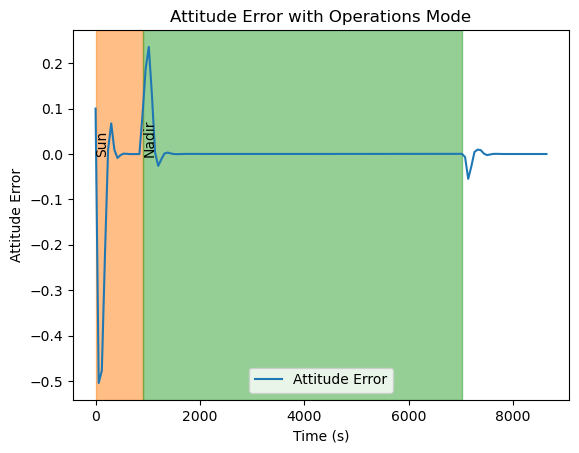

In [24]:
# plot the attitude error with background shading for the operations mode
import matplotlib.pyplot as plt

df_att_error = simulation.query_dataframe(computer.get_message("Out_AttitudeErrorMsg"))
df_ops_modes = simulation.query_dataframe(computer.get_message("Out_GuidanceChainMsg"))

# get the rows where the mode changes
df_ops_modes_diff = df_ops_modes[df_ops_modes["PointingMode"] != df_ops_modes["PointingMode"].shift(1)]


fig, ax = plt.subplots()
ax.plot(df_att_error.loc[:, "Time"], df_att_error.loc[:, "Sigma_BR_0"], label="Attitude Error")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Attitude Error")
ax.set_title("Attitude Error with Operations Mode")
ax.legend()

# add the background shading for the operations mode, change the color to differentiate between modes, and also annotate the mode

# add the background shading for the operations mode
for i in range(1, len(df_ops_modes_diff)):
    # ax.axvspan(df_ops_modes_diff.loc[:, "Time"].iloc[i-1], df_ops_modes_diff.loc[:, "Time"].iloc[i], color='gray', alpha=0.5)
    ax.axvspan(df_ops_modes_diff.loc[:, "Time"].iloc[i-1], df_ops_modes_diff.loc[:, "Time"].iloc[i], color=f"C{i}", alpha=0.5)
    # annotate the mode, placing the text at the left edge of the shaded region
    ax.text(df_ops_modes_diff.loc[:, "Time"].iloc[i-1], 0.0, df_ops_modes_diff.loc[:, "PointingMode"].iloc[i-1], rotation=90)

plt.show()

In [25]:
# plot the reaction wheel speeds
df_rw_speed = simulation.query_dataframe(reaction_wheels.get_message("Out_RWArraySpeedMsg"))
assert True

### Visualise the Ground Station Interaction

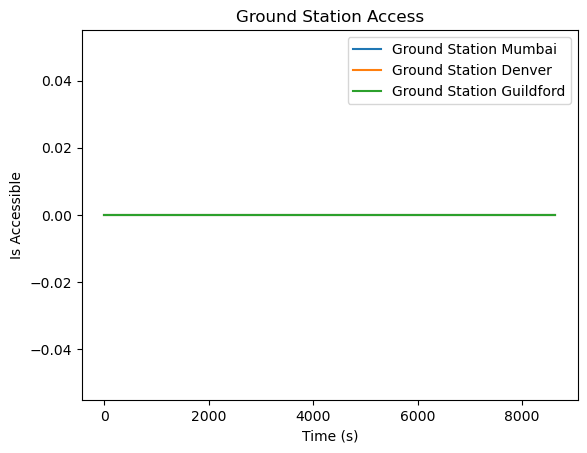

In [26]:
# plot the access of each ground station to the spacecraft

df_gs_access = []
for gs in ground_stations:
    df_gs_access.append(simulation.query_dataframe(gs["access_msg"]))
    
fig, ax = plt.subplots()
for i, df in enumerate(df_gs_access):
    ax.plot(df.loc[:, "Time"], df.loc[:, "IsAccessible"], label=f"Ground Station {list(ground_station_locations.keys())[i]}")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Is Accessible")
ax.set_title("Ground Station Access")
ax.legend()


In [27]:
# Visualise the number of packets loaded in the ground-station buffer yet to be transmitted
# create a pie chart to show the number of packets in the buffer

# get the data for the ground station
df_gs_access = []
for gs in ground_stations:
    df_gs_access.append(gs["transmitter"])
assert True

### Visualise the Power Consumption

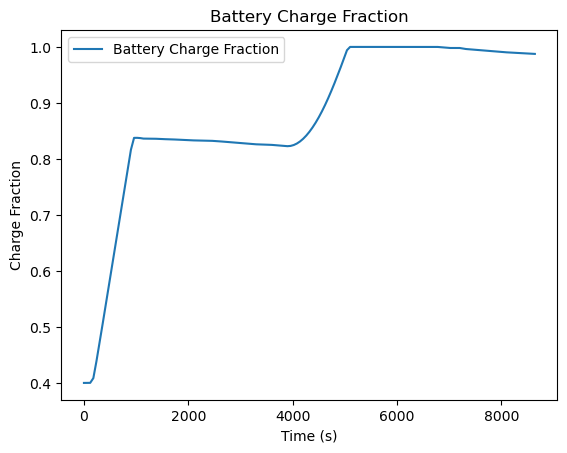

In [28]:
# plot the charge fraction of the battery
df_battery = simulation.query_dataframe(battery.get_message("Out_BatteryMsg"))

fig, ax = plt.subplots()
ax.plot(df_battery.loc[:, "Time"], df_battery.loc[:, "ChargeFraction"], label="Battery Charge Fraction")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Charge Fraction")
ax.set_title("Battery Charge Fraction")
ax.legend()
plt.show()

### Visualise the Onboared Data Storage

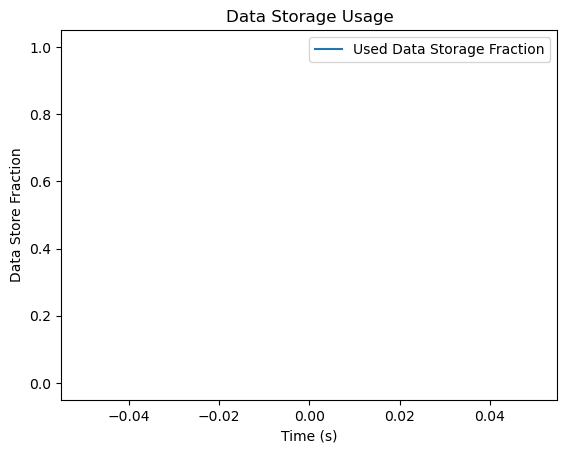

In [29]:
# plot the data storage usage
df_data_storage = simulation.query_dataframe(spacecraft_data_storage.get_message("Out_DataStorageMsg"))
# calculate the used fraction of the data storage based on the allocated memory and capacity
df_data_storage["UsedFraction"] = df_data_storage["Allocated"] / df_data_storage["Capacity"]


fig, ax = plt.subplots()
ax.plot(df_data_storage.loc[:, "Time"], df_data_storage.loc[:, "UsedFraction"], label="Used Data Storage Fraction")
# set the min value for the y-axis
ax.set_ylim(bottom=-0.05)
# set the max value for the y-axis
ax.set_ylim(top=1.05)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Data Store Fraction")
ax.set_title("Data Storage Usage")

ax.legend()
plt.show()